In [244]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [245]:
# Using a seemingly well-known movie review-sentiment-analyzing machine learning dataset.

In [246]:
filepath = './movie_reviews_data/review_polarity/txt_sentoken/'

In [247]:
from sklearn.datasets import load_files

In [248]:
data = load_files(filepath, random_state=42)

In [249]:
# This part's right:

data.target_names

['neg', 'pos']

# Experimenting and moving through the individual parts of the exercise before building the pipeline:

In [250]:
countvect = CountVectorizer()

In [251]:
X = countvect.fit_transform(data.data)
X.shape

(2000, 39659)

In [252]:
tf_transformer = TfidfTransformer(use_idf=False).fit(X)

In [253]:
X_train_tf = tf_transformer.transform(X)
X_train_tf.shape

(2000, 39659)

In [254]:
X1, X2, y1, y2 = train_test_split(X_train_tf, data.target, random_state=0)

In [255]:
naive_bayes = MultinomialNB().fit(X1, y1)

In [256]:
from sklearn.metrics import accuracy_score

In [257]:
y2_model = naive_bayes.predict(X2)
NBacc = accuracy_score(y2, y2_model)
"Naive Bayes gets you {0:.2f}% accuracy.".format(NBacc*100)

'Naive Bayes gets you 78.80% accuracy.'

In [258]:
# now for a SVM:

In [259]:
from sklearn.linear_model import SGDClassifier

In [260]:
svm = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=0, max_iter=4, tol=None)

In [261]:
support_vector = svm.fit(X1, y1)

In [262]:
better_y2_model = support_vector.predict(X2)
SVMacc = accuracy_score(y2, better_y2_model)
"Support-Vector Machine gets you {0:.2f}% accuracy.".format(SVMacc*100)

'Support-Vector Machine gets you 76.80% accuracy.'

In [263]:
# Okay that's weird, but maybe sample size isn't big enough, what with this being a great example of something
# that an algorithm can only do so well (and that's not very well). See if messing with cross-validation helps things:

In [264]:
from sklearn.cross_validation import cross_val_score

In [265]:
np.mean(cross_val_score(naive_bayes, X_train_tf, data.target, cv=500))

0.7175

In [266]:
np.mean(cross_val_score(support_vector, X_train_tf, data.target, cv=500))

0.735

In [267]:
# Okay so after all that work a 50/50 split Naive Bayes model seems no worse than a more sophisticated setup (though
# I do end up using one).

# On to actually building the data pipeline:

In [268]:
# pipeline for classification (using Naive Bayes for now):

review_sorter = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),])

In [269]:
# redefining some variables to make them the right format:

X1, X2, y1, y2 = train_test_split(data.data, data.target, random_state=0)

In [270]:
model = review_sorter.fit(X1, y1)

In [271]:
y2_model = model.predict(X2)
acc = accuracy_score(y2, y2_model)
"Naive Bayes gets you {0:.2f}% accuracy.".format(acc*100)

'Naive Bayes gets you 81.20% accuracy.'

In [272]:
from sklearn.metrics import classification_report

print(classification_report(y2, y2_model, target_names=data.target_names))

             precision    recall  f1-score   support

        neg       0.84      0.79      0.81       260
        pos       0.79      0.83      0.81       240

avg / total       0.81      0.81      0.81       500



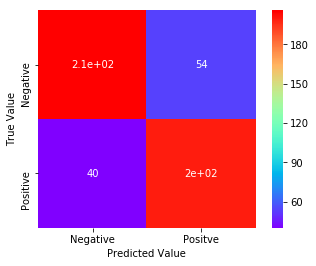

In [273]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(y2, y2_model)

sns.heatmap(mat, square=True, annot=True, cbar=True, cmap='rainbow', 
            xticklabels=['Negative', 'Positve'], 
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Value')
plt.ylabel('True Value');

# Now to redo after first tuning parameters:

In [274]:
from sklearn.model_selection import GridSearchCV

In [275]:
# Suppose I'm going to use a support-vector machine here, as it actually has parameters
# to tune.

In [276]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3),
              'clf__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
              'clf__l1_ratio': (0.01, 1),
              'clf__power_t': (0.01, 2)}

In [277]:
review_sorter = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=0.001, random_state=42,
                                           max_iter=5, tol=None))])

In [278]:
grid_search = GridSearchCV(review_sorter, parameters, n_jobs=-1)

In [279]:
grid_search = grid_search.fit(X1, y1)

In [280]:
for param in sorted(parameters.keys()):
    print("%s: %r" % (param, grid_search.best_params_[param]))

clf__alpha: 0.001
clf__l1_ratio: 0.01
clf__loss: 'modified_huber'
clf__power_t: 0.01
tfidf__use_idf: True
vect__ngram_range: (1, 1)


In [282]:
print('{0:.1f}%.'.format(grid_search.best_score_*100))

83.1%.


In [284]:
review_sorter = Pipeline([('vect', CountVectorizer(ngram_range=(1,1))),
                     ('tfidf', TfidfTransformer(use_idf=True)),
                     ('clf', SGDClassifier(loss='modified_huber', penalty='l2',
                                           alpha=0.001, random_state=42,
                                           max_iter=5, l1_ratio=0.01, power_t=0.01, tol=None))])

In [287]:
bestest_model = review_sorter.fit(X1, y1)

In [289]:
y2_model = bestest_model.predict(X2)
bestest_acc = accuracy_score(y2, y2_model)
"Bestest possible model gets you {0:.1f}% accuracy.".format(bestest_acc*100)

'Bestest possible model gets you 84.8% accuracy.'

### So there you go, an algorithm that does a sort-of-okay job of classifying movie reviews as positive or negative. If you're into that sort of thing. At least across the test set. I feel like the fallibility of even the bestest_model just goes to show that machine learning can't always beat actual thought.

In [294]:
print(classification_report(y2, y2_model, target_names=data.target_names))

             precision    recall  f1-score   support

        neg       0.84      0.88      0.86       260
        pos       0.86      0.82      0.84       240

avg / total       0.85      0.85      0.85       500



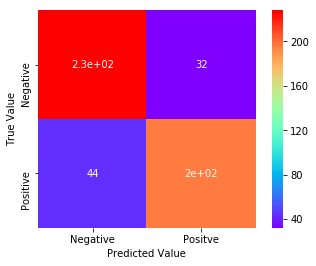

In [295]:
mat = confusion_matrix(y2, y2_model)

sns.heatmap(mat, square=True, annot=True, cbar=True, cmap='rainbow', 
            xticklabels=['Negative', 'Positve'], 
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Value')
plt.ylabel('True Value');